In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt

## 4. Training-Test Split

In [2]:
def build_tr_te_utd(bin_size):
    df = pd.read_csv("dating-unbinned.csv", index_col=[0])
    discrete = set(["gender", "race", "race_o", "samerace", "field", "decision"])
    continuous = list(set(df.columns) - discrete)
    for col in continuous:
        df[col] = df[col].apply(lambda x: int(np.floor(max(min(x, 9.99999), 0.000) / (10/bin_size))))
    test_set = df.sample(frac=0.2, random_state=47)
    train_set = df.loc[list(set(df.index) - set(test_set.index))]
    train_set.to_csv("trainingSet.csv")
    test_set.to_csv("testSet.csv")
def read_tr_te_utd():
    return pd.read_csv("trainingSet.csv", index_col=[0]), pd.read_csv("testSet.csv", index_col=[0])

## 5. Implement a Naive Bayes Classifier

In [3]:
class NBC:
    def __init__(self, col_names, bin_size):
        self.c2d = { # learned conditional prob
            col: []
            for col in col_names
        }
        self.c2all_set = {
            col: np.arange(bin_size)
            for col in col_names
        }
        self.y = [] # learned prob

        for name in ("gender", "race", "race_o", "field"):
            self.c2all_set[name] = np.arange(int(open(f"tmp/{name}.txt", "r").read()))
        self.c2all_set["samerace"] = np.arange(2)
        
    def fit(self, data):
        self.y = data["decision"].value_counts(normalize=True).reindex([0, 1], fill_value=0) 
        # nearly impossible to have all 0 or 1, but still need to handle
        for col in self.c2d:
            self.c2d[col] = (
                data[data["decision"] == 0][col].value_counts(normalize=True).reindex(self.c2all_set[col], fill_value=0),
                data[data["decision"] == 1][col].value_counts(normalize=True).reindex(self.c2all_set[col], fill_value=0),
            )
            # print(self.c2d[col][0])
            # print(self.c2d[col][1])
        
    def test(self, data, name, ban_print):
        tag_y = np.array(data["decision"])
        predict_y = np.array(self.y).reshape(-1, 1)
        for col in self.c2d:
            # firstly broadcast, then element-wise multiply
            predict_y = predict_y * np.array((
                                      self.c2d[col][0][data[col]], 
                                      self.c2d[col][1][data[col]]
                                    )) 
        predict_y = np.transpose(predict_y, (1, 0)).argmax(axis = 1)
        acc = np.sum(tag_y == predict_y) / tag_y.shape[0]
        if ban_print == 0:
            print(f"{name} Accuracy:  {acc}")
        return acc

In [4]:
def nbc(t_frac, bin_size = 5, ban_print = 0): # t_frac is the ratio of train data to be used to train
    if ban_print == 0:
        print(f"Bin size:  {bin_size}")
    
    # build the dataset
    build_tr_te_utd(bin_size)
    train_set, test_set = read_tr_te_utd()
    train_set = train_set.sample(frac=t_frac, random_state=47) # use a portion of whole train_set

    # fit and evaluate
    MLmodel = NBC(set(train_set.columns) - set(["decision"]), bin_size)
    MLmodel.fit(train_set)
    train_acc = MLmodel.test(train_set, "Training", ban_print = ban_print)
    test_acc = MLmodel.test(test_set, "Testing", ban_print = ban_print)
    return train_acc, test_acc
    


### 5.1 

In [5]:
nbc(1, 5) # just a test for the basic functionality

Bin size:  5
Training Accuracy:  0.7703429101019462
Testing Accuracy:  0.7272053372868792


(0.7703429101019462, 0.7272053372868792)

### 5.2 varying the number of bins

In [6]:
b_values = (2, 5, 10, 50, 100, 200)
train_accuracies, test_accuracies = [], []
for bin_size in b_values:
    train_acc, test_acc = nbc(1, bin_size)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
log_b_values = np.log(np.array(b_values))

Bin size:  2
Training Accuracy:  0.7215940685820204
Testing Accuracy:  0.6834692364714603
Bin size:  5
Training Accuracy:  0.7703429101019462
Testing Accuracy:  0.7272053372868792
Bin size:  10
Training Accuracy:  0.7873957367933272
Testing Accuracy:  0.7583395107487028
Bin size:  50
Training Accuracy:  0.7983317886932345
Testing Accuracy:  0.7479614529280949
Bin size:  100
Training Accuracy:  0.8009267840593142
Testing Accuracy:  0.748702742772424
Bin size:  200
Training Accuracy:  0.8088971269694162
Testing Accuracy:  0.7553743513713862


In [7]:
def Plot(x, train_y, test_y, name):
    plt.plot(x, train_y, label="Training Accuracy", marker='o')
    plt.plot(x, test_y, label="Test Accuracy", marker='o')
    plt.xlabel("Value of b")
    plt.ylabel("Accuracy")
    plt.title(f"Effect of b({name}) on NBC Model Performance")
    plt.legend()
    plt.grid(True)
    plt.show()

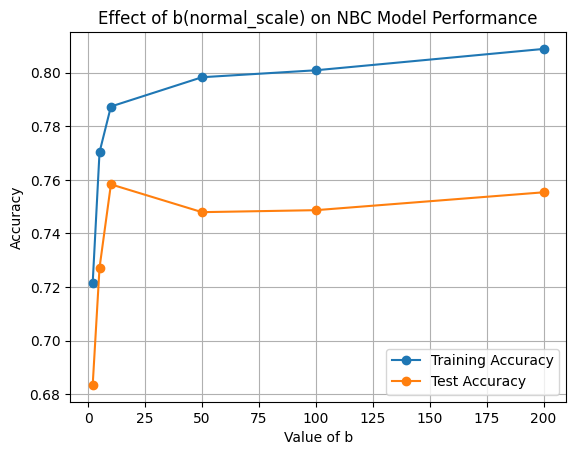

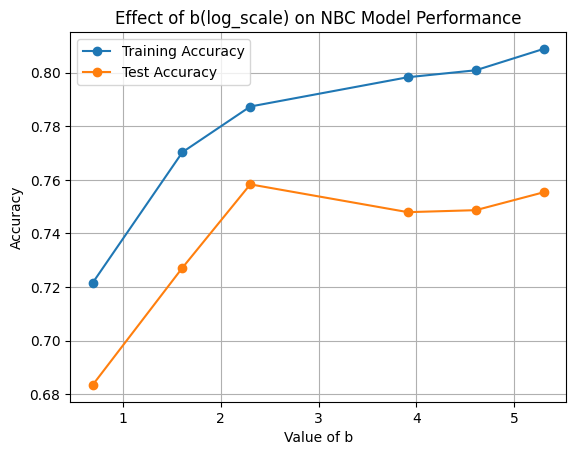

In [8]:
Plot(b_values, train_accuracies, test_accuracies, "normal_scale")
Plot(log_b_values, train_accuracies, test_accuracies, "log_scale")

#### We can found that:
1. At first, increasing the `bin_size` can gain a benefit both in train acc and test acc, which is mainly because the increasing `bin_size` retains more information of the original continuous data, thus can give the model more evidence to do the classification.
2. But later, increasing the `bin_size` will down the test acc, while still improving the train acc. I think there's overfitting happening because the over-detailed bin splitting makes the estimation of the cond prob in NBC less accurate and our model too complex (comparing with the data size)

### 5.3. varying the fraction


In [9]:
fraction_arr = (0.01, 0.1, 0.2, 0.5, 0.6, 0.75, 0.9, 1)
train_accuracies, test_accuracies = [], []
for frac in fraction_arr:
    train_acc, test_acc = nbc(frac, 5, ban_print = 1)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
log_fraction_arr = np.log(np.array(fraction_arr))

In [10]:
def Plot_(x, train_y, test_y, name):
    plt.plot(x, train_y, label="Training Accuracy", marker='o')
    plt.plot(x, test_y, label="Test Accuracy", marker='o')
    plt.xlabel("Value of frac")
    plt.ylabel("Accuracy")
    plt.title(f"Effect of FRAC({name}) on NBC Model Performance")
    plt.legend()
    plt.grid(True)
    plt.show()

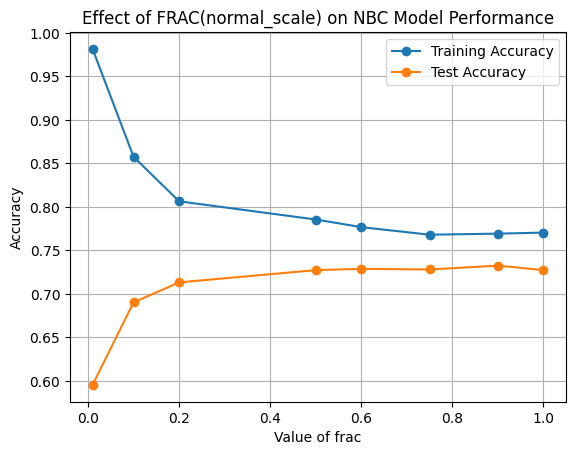

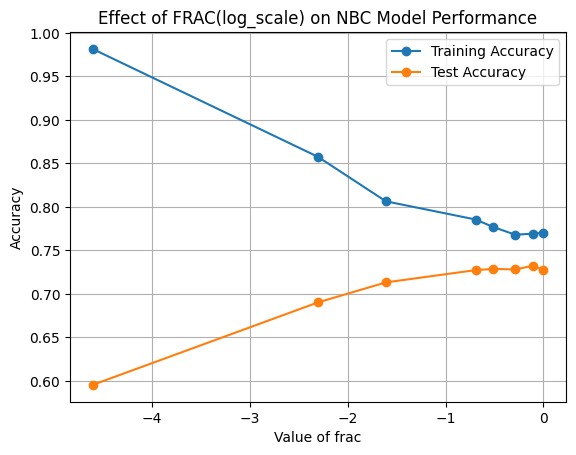

In [11]:
Plot_(fraction_arr, train_accuracies, test_accuracies, "normal_scale")
Plot_(log_fraction_arr, train_accuracies, test_accuracies, "log_scale")

In [12]:
train_accuracies, test_accuracies

([0.9814814814814815,
  0.8574074074074074,
  0.8063021316033364,
  0.7853965900667161,
  0.7766450417052827,
  0.7679189322787938,
  0.7691515650741351,
  0.7703429101019462],
 [0.5952557449962935,
  0.6901408450704225,
  0.7131208302446257,
  0.7272053372868792,
  0.7286879169755375,
  0.7279466271312083,
  0.7323943661971831,
  0.7272053372868792])

#### We can found that:
1. when the sample number of train dataset becomes more and more sufficient (`frac` goes up), the gap between train acc and test acc decrease rapidly, which means we learn a more general model.
2. In this case, the reason of decreasing of train acc is that we learn our model in a more broaden dataset, which avoids the overfitting, and is a good thing (which can be also concluded from the increasing test acc)